In [ ]:
!pip install --upgrade --force-reinstall numpy scipy ISLP pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 461.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.8/71.8 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.5/102.5 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 48.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.0/823.0 kB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.4/194.4 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 4.0 MB/s eta 0:00:0

In [ ]:
import numpy as np
import pandas as pd

from matplotlib.pyplot import subplots

from ISLP.models import ModelSpec as MS
from sklearn.model_selection import train_test_split

# Torch specific imports (main library and essential tools)
import torch
from torch import nn
from torch.optim import RMSprop
from torch.utils.data import TensorDataset

# Utilities to compute various metrics to evaluate performance when fitting a model
from torchmetrics import MeanAbsoluteError

# Summary of the layers of a model
from torchsummary import summary

# The package pytorch_lightning is a higher-level interface to torch that simplifies the specification and
# fitting of models by reducing the amount of code needed (compared to using torch alone).
from pytorch_lightning import (Trainer, seed_everything)
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import TQDMProgressBar

# SimpleDataModule and SimpleModule are simple versions of objects used in pytorch_lightning, implemented in ISLP.
from ISLP.torch import (SimpleDataModule, SimpleModule, ErrorTracker, rec_num_workers)

# Seed everything to have deterministic results
seed_everything(1, workers=True)
torch.use_deterministic_algorithms(True, warn_only=True)

INFO:lightning_fabric.utilities.seed:Seed set to 1


## Read the Data

In [ ]:
data = pd.read_csv('Advertising.csv', index_col=0)
data.dropna(inplace=True)
data

TV  radio  newspaper  sales
1    230.1   37.8       69.2   22.1
2     44.5   39.3       45.1   10.4
3     17.2   45.9       69.3    9.3
4    151.5   41.3       58.5   18.5
5    180.8   10.8       58.4   12.9
..     ...    ...        ...    ...
196   38.2    3.7       13.8    7.6
197   94.2    4.9        8.1    9.7
198  177.0    9.3        6.4   12.8
199  283.6   42.0       66.2   25.5
200  232.1    8.6        8.7   13.4

[200 rows x 4 columns]

## Split the data into training and test

In [ ]:
model = MS(data.columns.drop('sales'), intercept=False)
X = model.fit_transform(data).to_numpy()
Y = data['sales'].to_numpy()

(X_train, X_test, Y_train, Y_test) = train_test_split(X, Y, test_size=25,
                                                            random_state=1)

In [ ]:
print ("X_train Shape:", X_train.shape)
print ("Y_train Shape:", Y_train.shape)
print ("X_test Shape:", X_test.shape)
print ("X_test Shape:", Y_test.shape)

X_train Shape: (175, 3)
Y_train Shape: (175,)
X_test Shape: (25, 3)
X_test Shape: (25,)


In [ ]:
print ("Number of features:", X_train.shape[1])

Number of features: 3


# **Question 1**

## Set up the NN structure

In [ ]:
class AdvertisingModel(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, dropout_p=0.5, drop = False, norm = False):
        super(AdvertisingModel, self).__init__()
        self.norm = norm
        self.drop = drop

        # Layers: input -> h1 -> h2 -> output
        self.fc1 = nn.Linear(input_dim, hidden_dims[0])
        self.bn1 = nn.BatchNorm1d(hidden_dims[0])

        self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
        self.bn2 = nn.BatchNorm1d(hidden_dims[1])

        self.fc3 = nn.Linear(hidden_dims[1], output_dim)

        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(p=dropout_p)
        self.relu = nn.ReLU()

    def forward(self, x):
        # Hidden Layer 1
        x = self.flatten(x)
        x = self.fc1(x)
        if self.norm: x = self.bn1(x)
        x = self.relu(x)
        if self.drop: x = self.dropout(x)

        # Hidden Layer 2
        x = self.fc2(x)
        if self.norm: x = self.bn2(x)
        x = self.relu(x)
        if self.drop: x = self.dropout(x)

        # Output Layer
        x = self.fc3(x)

        return x.squeeze(-1)

## Instantiate NN

In [ ]:
# Define network dimensions
input_dim = X_train.shape[1]
hidden_dims = [128, 64]
output_dim = 1

# Instantiate the network
adv_model = AdvertisingModel(input_dim, hidden_dims, output_dim, dropout_p=0.5, drop = False, norm = False)
summary(adv_model, input_size=(X_train.shape[1],), batch_size=X_train.shape[0])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                   [175, 3]               0
            Linear-2                 [175, 128]             512
              ReLU-3                 [175, 128]               0
            Linear-4                  [175, 64]           8,256
              ReLU-5                  [175, 64]               0
            Linear-6                   [175, 1]              65
Total params: 8,833
Trainable params: 8,833
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.52
Params size (MB): 0.03
Estimated Total Size (MB): 0.55
----------------------------------------------------------------


## Transform the training data into a form accessible to torch.

In [ ]:
# Training tensor
X_train_t = torch.tensor(X_train.astype(np.float32))
Y_train_t = torch.tensor(Y_train.astype(np.float32))
adv_train = TensorDataset(X_train_t, Y_train_t)

# Test tensor
X_test_t = torch.tensor(X_test.astype(np.float32))
Y_test_t = torch.tensor(Y_test.astype(np.float32))
adv_test = TensorDataset(X_test_t, Y_test_t)

# Determine the recommended number of worker processes based on the system's capabilities
max_num_workers = rec_num_workers()

## Confirm shape of batches

In [ ]:
# prepare the dataset by organizing it into training, validation, and test sets,
# and defining how the data will be fed into the model during training and evaluation.
adv_dm = SimpleDataModule(adv_train, adv_test, batch_size=16,
                          num_workers=min(4, max_num_workers),
                          validation=25)

# Check the shape of the batch in the dataloader
for idx, (X_ ,Y_) in enumerate(adv_dm.train_dataloader()):
    print('X: ', X_.shape)
    print('Y: ', Y_.shape)
    if idx >= 1: # stop after 2 batches
        break

X:  torch.Size([16, 3])
Y:  torch.Size([16])
X:  torch.Size([16, 3])
Y:  torch.Size([16])


## Fit the Model

In [ ]:
# Set the learning rate
learning_rate = 0.001

# Configure Optimizer and Model Module
adv_optimizer = RMSprop(adv_model.parameters(), lr=learning_rate)
adv_module = SimpleModule.regression(adv_model, metrics={'mae':MeanAbsoluteError()}, optimizer=adv_optimizer)

# Set up Logging and progress bar
adv_logger = CSVLogger('logs', name='advertising')
progress_bar = TQDMProgressBar(refresh_rate=5, process_position=0)

adv_trainer = Trainer(deterministic = True, max_epochs = 150, logger = adv_logger,
                        enable_progress_bar = True, log_every_n_steps=5,
                        callbacks = [ErrorTracker() , progress_bar])

adv_trainer.fit(adv_module, datamodule=adv_dm)

INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | AdvertisingModel | 9.2 K  | train
1 | loss  | MSELoss          | 0      | train
---------------------------------------------------
9.2 K     Trainable params
0         Non-trainable params
9.2 K     Total params
0.037     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=150` reached.


In [ ]:
adv_results = pd.read_csv(adv_logger.experiment.metrics_file_path)
adv_results

epoch  step  train_loss  train_mae_epoch  train_mae_step  valid_loss  \
0        0     4         NaN              NaN        3.237632         NaN   
1        0     9         NaN              NaN        4.813829         NaN   
2        0     9         NaN              NaN             NaN   42.852417   
3        0     9  189.425949         8.596234             NaN         NaN   
4        1    14         NaN              NaN        3.015364         NaN   
..     ...   ...         ...              ...             ...         ...   
595    148  1489    1.599121         0.952541             NaN         NaN   
596    149  1494         NaN              NaN        0.911273         NaN   
597    149  1499         NaN              NaN        1.781060         NaN   
598    149  1499         NaN              NaN             NaN    6.218925   
599    149  1499    1.817921         0.987157             NaN         NaN   

     valid_mae  
0          NaN  
1          NaN  
2     5.879011  
3          NaN  
4          NaN  
..         ...  
595        NaN  
596        NaN  
597        NaN  
598   2.133171  
599        NaN  

[600 rows x 7 columns]

## Plot the Training and Validation MAE

In [ ]:
def summary_plot(results, ax, col='mae', valid_legend='Validation',
                 training_legend='Training', ylabel='MAE', fontsize=20):
    for (column, color, label) in zip([f'train_{col}_epoch', f'valid_{col}'],
                                      ['black', 'red'],
                                      [training_legend, valid_legend]):
        results.plot(x='epoch', y=column, label=label, marker='o', color=color, ax=ax)
    ax.set_xlabel('Epoch')
    ax.set_ylabel(ylabel)
    return ax

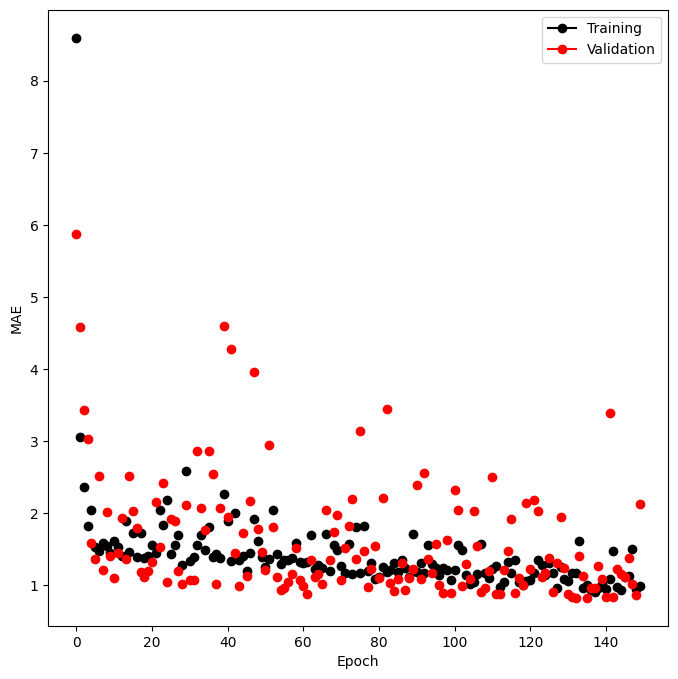

In [ ]:
fig, ax = subplots(1, 1, figsize=(8, 8))
ax = summary_plot(adv_results, ax, col='mae', ylabel='MAE')

# **Question 2**

**MAE Graph**

As observed in the MAE graph, both training and validation errors exhibit high variability during the early epochs, with the training MAE dropping dramatically after the first epoch.

Up until around the 80th epoch, the validation error fluctuates widely—roughly between 0.5 and 3.5—while the training error remains relatively stable.

Beyond the 80th epoch, both metrics converge to a narrower range (about 0.5 to 2), except from a spike in the validation MAE at the 140th epoch, indicating that the model parameters have stabilized and the optimizer is converging effectively.

Additionally, the close tracking between training and validation MAE suggests that the network is not severely overfitting.

**Choice of Units**

I experimented with three architectures: (256,128,1), (64,32,1), and (128,64,1) and found that the (256,128,1) model overfitted the small dataset while the (64,32,1) configuration underfitted. The 128–64–1 architecture struck the right balance, effectively capturing the underlying relationships without overfitting. Ultimately, this model achieved the best performance in terms of lower test loss and MAE, making it the most suitable choice for this advertising dataset.

# **Question 3: Dropout and Batch Normalization**

In [ ]:
# Instantiate the new model
adv_model_norm = AdvertisingModel(input_dim, hidden_dims, output_dim, dropout_p=0.1,
                                  drop=True, norm=True)
summary(adv_model_norm, input_size=(X_train.shape[1],), batch_size=X_train.shape[0])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                   [175, 3]               0
            Linear-2                 [175, 128]             512
       BatchNorm1d-3                 [175, 128]             256
              ReLU-4                 [175, 128]               0
           Dropout-5                 [175, 128]               0
            Linear-6                  [175, 64]           8,256
       BatchNorm1d-7                  [175, 64]             128
              ReLU-8                  [175, 64]               0
           Dropout-9                  [175, 64]               0
           Linear-10                   [175, 1]              65
Total params: 9,217
Trainable params: 9,217
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 1.03
Params size (MB): 0.04
Estimated Total

In [ ]:
adv_optimizer_norm = RMSprop(adv_model_norm.parameters(), lr=learning_rate)
adv_module_norm = SimpleModule.regression(adv_model_norm,
                                          metrics={'mae': MeanAbsoluteError()},
                                          optimizer=adv_optimizer_norm)
adv_trainer_norm = Trainer(deterministic = True, max_epochs = 150, logger = adv_logger,
                        enable_progress_bar = True, log_every_n_steps=5,
                        callbacks = [ErrorTracker() , progress_bar])

adv_trainer_norm.fit(adv_module_norm, datamodule=adv_dm)

INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory logs/advertising/version_7/checkpoints exists and is not empty.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | AdvertisingModel | 9.2 K  | train
1 | loss  | MSELoss          | 0      | train
---------------------------------------------------
9.2 K     Trainable params
0         Non-trainable params
9.2 K     Total params
0.037     Total estimated model par

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=150` reached.


In [ ]:
adv_results_norm = pd.read_csv(adv_logger.experiment.metrics_file_path)
adv_results_norm

epoch  step  test_loss  test_mae  train_loss  train_mae_epoch  \
0         0     4        NaN       NaN         NaN              NaN   
1         0     9        NaN       NaN         NaN              NaN   
2         0     9        NaN       NaN         NaN              NaN   
3         0     9        NaN       NaN  189.425949         8.596234   
4         1    14        NaN       NaN         NaN              NaN   
...     ...   ...        ...       ...         ...              ...   
3604    148  1489        NaN       NaN    3.503696         1.494838   
3605    149  1494        NaN       NaN         NaN              NaN   
3606    149  1499        NaN       NaN         NaN              NaN   
3607    149  1499        NaN       NaN         NaN              NaN   
3608    149  1499        NaN       NaN    4.344769         1.622827   

      train_mae_step  valid_loss  valid_mae  
0           3.237632         NaN        NaN  
1           4.813829         NaN        NaN  
2                NaN   42.852417   5.879011  
3                NaN         NaN        NaN  
4           3.015364         NaN        NaN  
...              ...         ...        ...  
3604             NaN         NaN        NaN  
3605        0.939973         NaN        NaN  
3606        1.528753         NaN        NaN  
3607             NaN    2.110547   1.179934  
3608             NaN         NaN        NaN  

[3609 rows x 9 columns]

## Plot the Training and Validation MAE

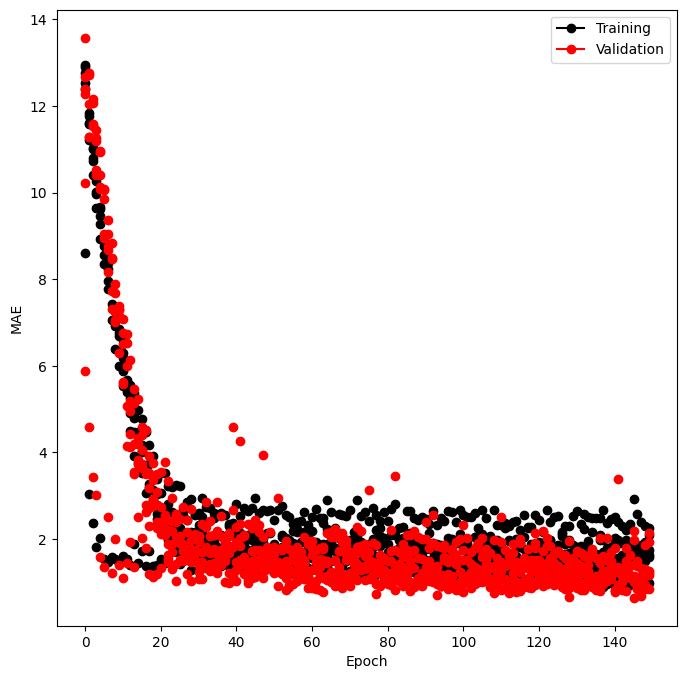

In [ ]:
fig, ax = subplots(1, 1, figsize=(8, 8))
ax = summary_plot(adv_results_norm, ax, col='mae', ylabel='MAE')

The MAE graph **with** normalization and dropout exhibits more stable and consistent performance compared to the MAE graph **without** these techniques.

It seems that batch normalization helps by stabilizing the hidden layer inputs, which smooths out the gradient updates and accelerates convergence, while dropout reduces overfitting by randomly deactivating a portion of the neurons during training.

As a result, the model with normalization and dropout shows fewer drastic spikes and a smaller gap between training and validation MAE, indicating better generalization. In contrast, the model without these regularization techniques is more prone to variability and struggles to maintain stable performance on unseen data.

I chose a dropout value of 0.1 because, after experimenting with different settings, it provided sufficient regularization for the small dataset without significantly hindering the model's capacity to learn complex patterns. Even this  very modest dropout rate helped reduce overfitting considerably while maintaining performance.

# **Question 4**

In [ ]:
adv_trainer.test(adv_module, datamodule=adv_dm)

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    5.8850321769714355     │
│         test_mae          │    2.0860745906829834     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 5.8850321769714355, 'test_mae': 2.0860745906829834}]

In [ ]:
adv_trainer_norm.test(adv_module_norm, datamodule=adv_dm)

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    1.4408363103866577     │
│         test_mae          │    0.9989490509033203     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.4408363103866577, 'test_mae': 0.9989490509033203}]

The model with dropout and normalization significantly outperformed the one without, as shown by a lower test loss (1.44 vs. 5.89) and reduced test MAE (1.00 vs. 2.09). This improvement suggests that the regularization and normalization techniques effectively mitigated overfitting and enhanced the model's ability to generalize to unseen data (25 observations of the test data set). In contrast, the model without these techniques appears to have overfit the training data, leading to much higher errors on the test set.

Overall, these results confirm that incorporating dropout and batch normalization yields a more robust predictive model.